In [10]:
import climakitae as ck
from climakitae.core.data_interface import get_data
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import geopandas as gpd
import rioxarray as rxr
import os
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    print("Cartopy still not working, try pip install cartopy")
    ccrs = None

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams['figure.dpi'] = 150
STANDARD_CRS = "EPSG:4326"

output_dir = "OutputImages"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"created dir called: {output_dir}")
else:
    print(f"output image dir already exists: {output_dir}")

from climakitae.core.data_interface import get_data_options
cariablesToCheck = ["Air Temperature at 2m", "Precipitation (total)"]
for car in cariablesToCheck:
    print(f"\nVariable: {car}")
    try:
        optionsDf = get_data_options(variable=car)
        grouped_options = optionsDf.groupby('downscaling_method')['resolution'].unique()
        if grouped_options.empty:
            print("bug no rezzy in df selection in line above")
        else:
            for method, resolutions in grouped_options.items():
                print(f" Method: {method}")
                print(f"\tResolutions: {list(resolutions)}")
    except Exception as e:
        print(f"problem with options for {car}. err as seen by: {e}")

mojaveShapeRelativePath = "../data/Mojave_National_Preserve.shp"
try:
    mojaveBoundary = gpd.read_file(mojaveShapeRelativePath)
    if mojaveBoundary.crs != STANDARD_CRS:
        print(f"Reprojecting boundary from {mojaveBoundary.crs} to {STANDARD_CRS}...")
        mojaveBoundary = mojaveBoundary.to_crs(STANDARD_CRS)
    bounds = mojaveBoundary.total_bounds
    longitude_slice = (bounds[0], bounds[2])
    latitude_slice = (bounds[1], bounds[3])
    print(f"bounds:Lat {latitude_slice}, Longi {longitude_slice}")
except Exception as e:
    print(f"err w/ loading shapefile @ {mojaveShapeRelativePath}: {e}")
    mojaveBoundary = None
    longitude_slice = (-116.2, -114.7)
    latitude_slice = (34.5, 35.9)

VARIABLES = {"temp": "Air Temperature at 2m", "precip": "Precipitation (total)"}
SCENARIOS = ["Historical Climate", "SSP 3-7.0"]
RESOLUTION = "3 km"
BASELINE_PERIOD = {"name": "Baseline (1985-2014)", "years": (1985, 2014)}
FUTURE_PERIOD = {"name": "Late-Century (2071-2100)", "years": (2071, 2100)}
TIME_SPAN = (BASELINE_PERIOD["years"][0], FUTURE_PERIOD["years"][1])

data_dict = {}
for key, varName in VARIABLES.items():
    try:
        print(f"Retrieving {key}...")
        data = get_data(
            variable=varName,
            resolution=RESOLUTION,
            timescale="monthly",
            scenario=SCENARIOS,
            time_slice=TIME_SPAN,
            latitude=latitude_slice,
            longitude=longitude_slice
        )
        data_dict[key] = data
    except Exception as e:
        print(f"Error retrieving {key}: {e}")
        data_dict[key] = None

if 'temp' in data_dict and data_dict['temp'] is not None:
    if data_dict['temp'].attrs.get('units') == 'K':
        data_dict['temp'] = data_dict['temp'] - 273.15
        data_dict['temp'].attrs['units'] = '°C'

optionsDf = get_data_options(variable="Air Temperature at 2m")
print("all columns are:", optionsDf.columns.to_list())
if 'temp' in data_dict and data_dict['temp'] is not None:
    data = data_dict['temp']
    if 'simulation' in data.dims:
        simulation_names = data.simulation.values
        for sim_name in simulation_names:
            print(f"~{sim_name}")
    else:
        print("simulation dimen wasn't found-- shoudln't happen")
else:
    print("data dict in prior cells probably isn't loaded")

for key, data in data_dict.items():
    if data is None:
        continue
    print(f"\nVarable: {key}")
    print("  Dimensions:")
    for dim, size in data.sizes.items():
        print(f"    - {dim}: {size}")
    print("  CRS Information:")
    dataCrs = data.rio.crs
    if dataCrs:
        print(f"  - CRS: {dataCrs.to_string()[:150]}...")
    else:
        print("    - CRS: Not Found")
    print("  Auxiliary Coordinate Shapes Check:")
    aux_coords = ['lat', 'lon', 'landmask', 'lakemask']
    data_shape = (data.sizes.get('y', 'N/A'), data.sizes.get('x', 'N/A'))
    print(f"    Main Data Shape (y, x): {data_shape}")
    mismatchdDetected = False
    for coord in aux_coords:
        if coord in data.coords:
            coord_shape = (data[coord].sizes.get('y', 'N/A'), data[coord].sizes.get('x', 'N/A'))
            print(f"    -Coord '{coord}' Shape in (y, x)form is: {coord_shape}")
            if coord_shape != data_shape:
                print(f"      Warning: shape mismatch for '{coord}',has to be dropped before reprojection happens.")
                mismatchdDetected = True
    if not mismatchdDetected:
        print(" No shape mismatches for aux coords")


output image dir already exists: OutputImages

Variable: Air Temperature at 2m
 Method: Dynamical
	Resolutions: ['45 km', '9 km', '3 km']

Variable: Precipitation (total)
 Method: Dynamical
	Resolutions: ['45 km', '9 km', '3 km']
 Method: Statistical
	Resolutions: ['3 km']
Reprojecting boundary from EPSG:4269 to EPSG:4326...
bounds:Lat (np.float64(34.71693048361919), np.float64(35.59077455259237)), Longi (np.float64(-116.16503220167623), np.float64(-114.94916062294271))
Retrieving temp...
Retrieving precip...
all columns are: ['variable', 'resolution']
~WRF_FGOALS-g3_r1i1p1f1
~WRF_CNRM-ESM2-1_r1i1p1f2
~WRF_MPI-ESM1-2-HR_r3i1p1f1
~WRF_CESM2_r11i1p1f1
~WRF_EC-Earth3-Veg_r1i1p1f1
~WRF_TaiESM1_r1i1p1f1
~WRF_MIROC6_r1i1p1f1
~WRF_EC-Earth3_r1i1p1f1

Varable: temp
  Dimensions:
    - scenario: 1
    - simulation: 8
    - time: 1388
    - y: 46
    - x: 48
  CRS Information:
  - CRS: PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,A

In [11]:
def calculate_period_climatology(dataArray, startyear, endYear, varType):
    safe_start = str(startyear - 1)
    periodData = dataArray.sel(time=slice(safe_start, str(endYear)))
    current_scenarios = list(np.atleast_1d(periodData.scenario.to_numpy())) if "scenario" in periodData.coords else []
    if startyear < 2015:
        if "Historical Climate" in current_scenarios:
            scenario_to_select = "Historical Climate"
        elif len(current_scenarios) > 0:
            scenario_to_select = current_scenarios[0]
        else:
            return None
        if 'scenario' in periodData.dims:
            periodData = periodData.sel(scenario=scenario_to_select, drop=True)
        else:
            periodData = periodData.drop_vars('scenario', errors='ignore')
    else:
        if 'scenario' not in periodData.dims and len(current_scenarios) > 0:
            periodData = periodData.expand_dims(dim={'scenario': current_scenarios})
    if varType == 'precip':
        quarterly_data = periodData.resample(time='QS-DEC').sum(dim='time')
    else:
        quarterly_data = periodData.resample(time='QS-DEC').mean(dim='time')
    quarterly_climatology = quarterly_data.groupby('time.quarter').mean(dim='time')
    return quarterly_climatology

climatologies = {}
for key, data in data_dict.items():
    if data is not None:
        baseline_q = calculate_period_climatology(
            data, BASELINE_PERIOD["years"][0], BASELINE_PERIOD["years"][1], key
        )
        future_q = calculate_period_climatology(
            data, FUTURE_PERIOD["years"][0], FUTURE_PERIOD["years"][1], key
        )
        climatologies[key] = {
            "baseline_quarterly": baseline_q,
            "future_quarterly": future_q
        }

WARMEST_Q_IDX = None
COLDEST_Q_IDX = None
if 'temp' in climatologies and climatologies['temp']['baseline_quarterly'] is not None:
    temp_data = climatologies['temp']['baseline_quarterly']
    if 'lat' in temp_data.coords:
        weights = np.cos(np.deg2rad(temp_data.lat)).fillna(0)
        avg_q_cycle = temp_data.weighted(weights).mean(dim=['simulation', 'x', 'y'], skipna=True)
    else:
        avg_q_cycle = temp_data.mean(dim=['simulation', 'x', 'y'], skipna=True)
    avg_q_cycle.load()
    WARMEST_Q_IDX = avg_q_cycle.idxmax(dim='quarter').item()
    COLDEST_Q_IDX = avg_q_cycle.idxmin(dim='quarter').item()
    print(f"most warm q Index: {WARMEST_Q_IDX}, coldest q Idx: {COLDEST_Q_IDX}")

def calculate_anomalies(baseline, future, varType):
    if baseline is None or future is None:
        return None
    if varType == 'precip':
        epsilon = 1e-9
        anomalies = xr.where(
            abs(baseline) > epsilon,
            ((future - baseline) / baseline) * 100,
            0
        )
        unit = '% Change'
    else:
        anomalies = (future - baseline)
        origUnits = data_dict.get(varType, {}).attrs.get('units', 'C')
        unit = f"Δ{origUnits}"
    ensembleMeanAnomaly = anomalies.mean(dim='simulation')
    ensembleMeanAnomaly.attrs['units'] = unit
    return ensembleMeanAnomaly

anomalies_dict = {}
if 'precip' in climatologies:
    anomalies_dict['precip_quarterly'] = calculate_anomalies(
        climatologies['precip']['baseline_quarterly'],
        climatologies['precip']['future_quarterly'],
        'precip'
    )

if 'temp' in climatologies and WARMEST_Q_IDX is not None:
    baselineMostWarm = climatologies['temp']['baseline_quarterly'].sel(quarter=WARMEST_Q_IDX)
    futureMostWarm = climatologies['temp']['future_quarterly'].sel(quarter=WARMEST_Q_IDX)
    baselineColdest = climatologies['temp']['baseline_quarterly'].sel(quarter=COLDEST_Q_IDX)
    futureColdest = climatologies['temp']['future_quarterly'].sel(quarter=COLDEST_Q_IDX)
    anomalies_dict['temp_warmest_q'] = calculate_anomalies(baselineMostWarm, futureMostWarm, 'temp')
    anomalies_dict['temp_coldest_q'] = calculate_anomalies(baselineColdest, futureColdest, 'temp')

most warm q Index: 2.0, coldest q Idx: 4.0


/opt/conda/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


Saved plot to OutputImages/Mojave_Quarterly_Precipitation_Anomalies.png


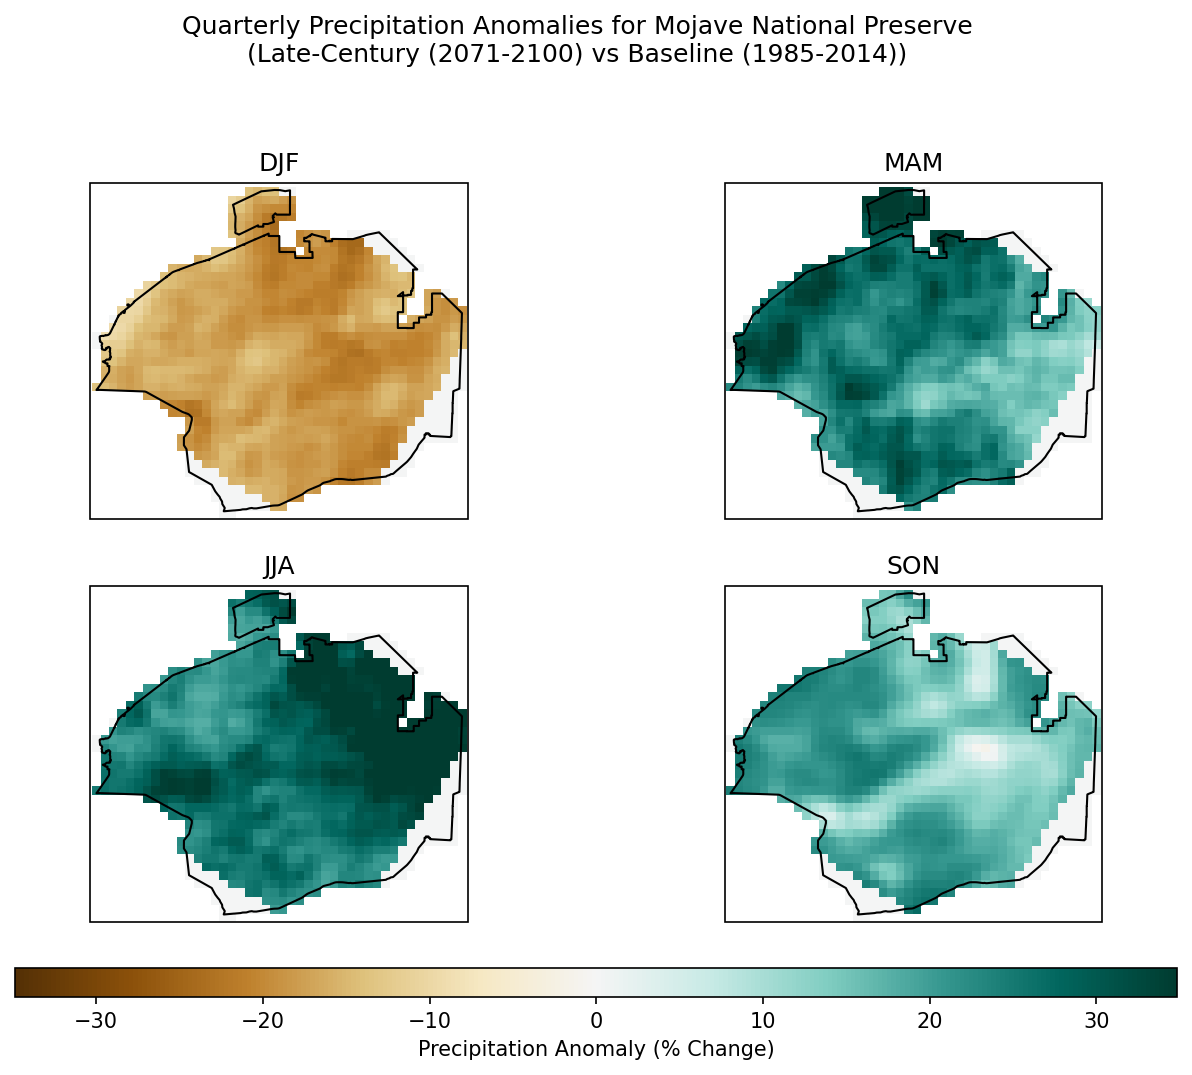

Saved plot to OutputImages/Mojave_Temp_WarmCold_Anomalies.png


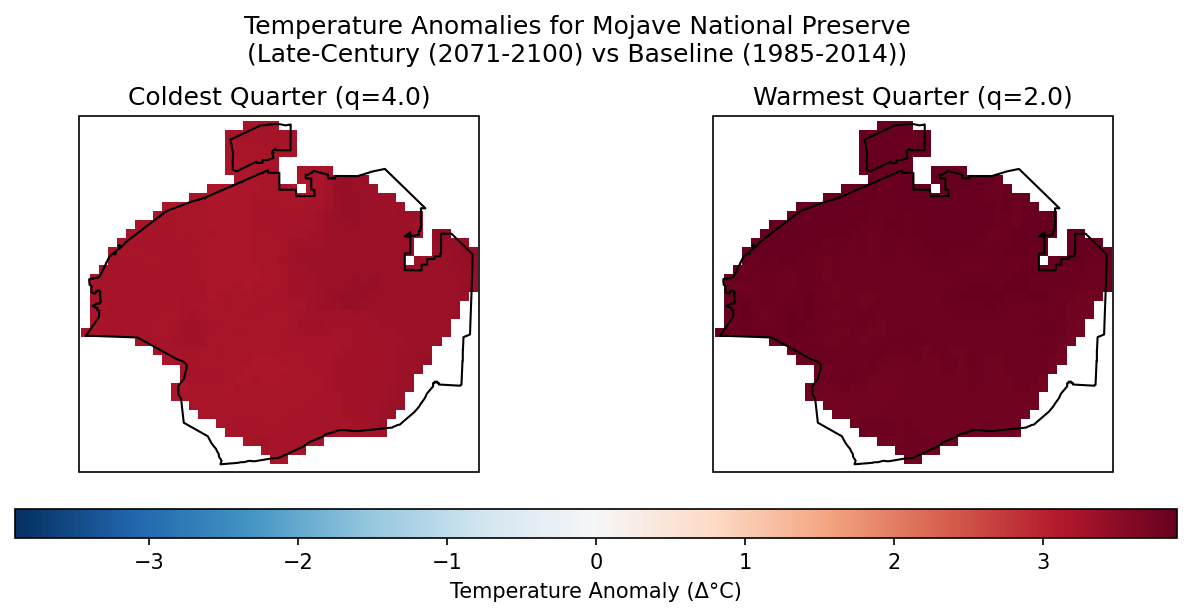

In [12]:
def attach_xy_from_latlon(da):
    if "lon" in da.coords and "lat" in da.coords:
        try:
            x_vals = da["lon"].mean("y").values
            y_vals = da["lat"].mean("x").values
            da = da.assign_coords(x=("x", x_vals), y=("y", y_vals))
        except Exception as e:
            print("failed to attach x/y from lat/lon:", e)
    try:
        da = da.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    except Exception as e:
        print("set_spatial_dims fail:", e)
    try:
        da = da.rio.write_crs(STANDARD_CRS, inplace=False)
    except Exception as e:
        print("write_crs fail:", e)
    return da

def reproject_and_clip(dataArray, bondaryGDF):
    if dataArray is None:
        return None
    da = dataArray.drop_vars(['landmask', 'lakemask'], errors='ignore')
    da = attach_xy_from_latlon(da)
    if bondaryGDF is None:
        return da
    try:
        clipAttributes = da.rio.clip(bondaryGDF.geometry.values, drop=True, all_touched=True)
        clipAttributes.attrs.update(dataArray.attrs)
        return clipAttributes
    except Exception as e:
        print(f"Error during clipping: {e}")
        return da

clipped_anomalies = {}
for key in ['precip_quarterly', 'temp_warmest_q', 'temp_coldest_q']:
    if key in anomalies_dict and anomalies_dict[key] is not None:
        data = anomalies_dict[key].squeeze(drop=True)
        clipped_anomalies[key] = reproject_and_clip(data, mojaveBoundary)

if ccrs and 'precip_quarterly' in clipped_anomalies and clipped_anomalies['precip_quarterly'] is not None:
    dataToPlot = clipped_anomalies['precip_quarterly'].squeeze(drop=True)
    if "season" in dataToPlot.dims and "quarter" not in dataToPlot.dims:
        dataToPlot = dataToPlot.rename({"season": "quarter"})
    extra_dims = [d for d in dataToPlot.dims if d not in ["quarter", "y", "x"]]
    if extra_dims:
        if "scenario" in extra_dims and "scenario" in dataToPlot.coords:
            if "SSP 3-7.0" in list(np.atleast_1d(dataToPlot.scenario.values)):
                dataToPlot = dataToPlot.sel(scenario="SSP 3-7.0", drop=True)
            else:
                dataToPlot = dataToPlot.mean(dim="scenario", skipna=True)
            extra_dims = [d for d in dataToPlot.dims if d not in ["quarter", "y", "x"]]
        if extra_dims:
            dataToPlot = dataToPlot.mean(dim=extra_dims, skipna=True)
    if set(["quarter", "y", "x"]).issubset(dataToPlot.dims):
        dataToPlot = dataToPlot.transpose("quarter", "y", "x")
    q_names = {1: 'DJF', 2: 'MAM', 3: 'JJA', 4: 'SON'}
    quarters = [q for q in [1,2,3,4] if q in list(np.atleast_1d(dataToPlot.quarter.values))]
    if hasattr(dataToPlot.data, 'dask'):
        dataToPlot.load()
    vmin, vmax = np.nanpercentile(dataToPlot, [5, 95])
    v_limit = max(abs(vmin), abs(vmax))
    projectsion = ccrs.PlateCarree()
    fig, axes = plt.subplots(2, 2, figsize=(10,8), subplot_kw={'projection': projectsion})
    axes = axes.flatten()
    buffer = 0.02
    plot_extent = [longitude_slice[0]-buffer, longitude_slice[1]+buffer,
                   latitude_slice[0]-buffer,  latitude_slice[1]+buffer]
    for ax, q in zip(axes, quarters):
        da_q = dataToPlot.sel(quarter=q).squeeze(drop=True)
        extra2 = [d for d in da_q.dims if d not in ["y", "x"]]
        if extra2:
            da_q = da_q.mean(dim=extra2, skipna=True)
        da_q.plot(ax=ax, cmap='BrBG', center=0, vmin=-v_limit, vmax=v_limit, add_colorbar=False)
        if mojaveBoundary is not None:
            mojaveBoundary.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_extent(plot_extent, crs=projectsion)
        ax.set_title(q_names.get(int(q), f"Q{int(q)}"))
    for k in range(len(quarters), 4):
        axes[k].axis("off")
    fig.colorbar(
        axes[0].collections[0],
        ax=axes,
        orientation='horizontal',
        pad=0.05,
        aspect=40,
        label=f"Precipitation Anomaly ({dataToPlot.attrs.get('units','%')})"
    )
    fig.suptitle(
        f'Quarterly Precipitation Anomalies for Mojave National Preserve\n'
        f'({FUTURE_PERIOD["name"]} vs {BASELINE_PERIOD["name"]})',
        y=1.02
    )
    save_path = os.path.join(output_dir, "Mojave_Quarterly_Precipitation_Anomalies.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved plot to {save_path}")
    plt.show()
else:
    print("missing libs needed for precip plot or 'precip_quarterly' key")

if ccrs and 'temp_warmest_q' in clipped_anomalies and 'temp_coldest_q' in clipped_anomalies:
    warm = clipped_anomalies['temp_warmest_q'].squeeze(drop=True)
    cold = clipped_anomalies['temp_coldest_q'].squeeze(drop=True)
    for nm in ["warm", "cold"]:
        da = locals()[nm]
        extra_dims = [d for d in da.dims if d not in ["y", "x"]]
        if extra_dims:
            locals()[nm] = da.mean(dim=extra_dims, skipna=True)
    warm = locals()["warm"]
    cold = locals()["cold"]
    combined = xr.concat([warm, cold], dim="panel")
    vmin, vmax = np.nanpercentile(combined, [5, 95])
    v_limit = max(abs(vmin), abs(vmax))
    projectsion = ccrs.PlateCarree()
    fig, axes = plt.subplots(1, 2, figsize=(10,4), subplot_kw={'projection': projectsion})
    buffer = 0.02
    plot_extent = [longitude_slice[0]-buffer, longitude_slice[1]+buffer,
                   latitude_slice[0]-buffer,  latitude_slice[1]+buffer]
    for ax, da, title in zip(
        axes,
        [cold, warm],
        [f"Coldest Quarter (q={COLDEST_Q_IDX})", f"Warmest Quarter (q={WARMEST_Q_IDX})"]
    ):
        da.plot(ax=ax, cmap='RdBu_r', center=0, vmin=-v_limit, vmax=v_limit, add_colorbar=False)
        if mojaveBoundary is not None:
            mojaveBoundary.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_extent(plot_extent, crs=projectsion)
        ax.set_title(title)
    fig.colorbar(
        axes[0].collections[0],
        ax=axes,
        orientation='horizontal',
        pad=0.08,
        aspect=40,
        label=f"Temperature Anomaly ({warm.attrs.get('units','Δ°C')})"
    )
    fig.suptitle(
        f'Temperature Anomalies for Mojave National Preserve\n'
        f'({FUTURE_PERIOD["name"]} vs {BASELINE_PERIOD["name"]})',
        y=1.05
    )
    save_path = os.path.join(output_dir, "Mojave_Temp_WarmCold_Anomalies.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved plot to {save_path}")
    plt.show()
else:
    print("missing libs / data for temp warm/cold plot")
